In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import pathlib
import shutil

data_dir_path = '/kaggle/input/labeled-mask-dataset-yolo-darknet'

data_dir = pathlib.Path(data_dir_path + "/obj/").with_suffix('')

image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


/kaggle/input/labeled-mask-dataset-yolo-darknet/obj/masked (1315).jpg


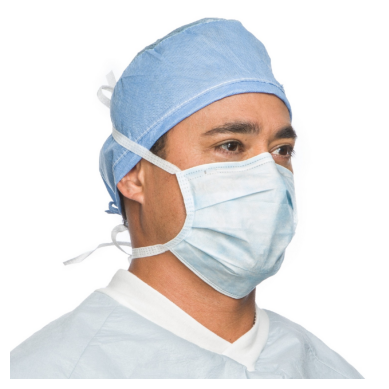

In [6]:
sample_img_path = str(image_files[103])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [8]:
import os, random

def list_files(full_data_path = "/kaggle/input/labeled-mask-dataset-yolo-darknet/obj/", image_ext = '.jpg', split_percentage = [70, 20]):
    

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]


In [10]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


In [12]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

In [13]:
import tensorflow as tf 
def data_load(files, full_data_path = "/kaggle/input/labeled-mask-dataset-yolo-darknet/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
raw_train_ds = data_load(training_files)

In [15]:
raw_validation_ds = data_load(validation_files)

In [16]:
raw_test_ds = data_load(test_files)

In [20]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [21]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [22]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [23]:
validation_ds = tune_validation_ds(raw_validation_ds)

## Model

### Zadanie: Klasyfikacja i Regresja w Detekcji Obiektów

Twoim zadaniem jest stworzenie modelu sieci neuronowej do detekcji obiektów, który łączy w sobie zarówno zadania klasyfikacji, jak i regresji. Zaprojektowana sieć będzie przyjmować obrazy o wymiarach `(input_size, input_size, 1)` i wykonywać następujące operacje:

1. **Ekstrakcja cech**: Zaimplementowana funkcja `build_feature_extractor(inputs)` przyjmuje obrazy jako wejście i przeprowadza ekstrakcję cech, wykorzystując warstwy konwolucyjne i warstwy max-pooling.

2. **Model Adaptor**: Funkcja `build_model_adaptor(inputs)` przyjmuje wyekstrahowane cechy i przekształca je na jednowymiarowy wektor za pomocą warstw `Flatten` i `Dense`.

3. **Klasyfikacja**: Funkcja `build_classifier_head(inputs)` przyjmuje wyjście z modelu adaptora i dokonuje klasyfikacji na określoną liczbę klas (parametr `n_classes`) za pomocą warstwy `Dense` i funkcji aktywacji softmax.

4. **Regresja**: Funkcja `build_regressor_head(inputs)` również przyjmuje wyjście z modelu adaptora, ale w tym przypadku przewiduje wartości numeryczne, wykorzystując warstwę `Dense` bez funkcji aktywacji.

5. Trening: Wytrenuj model na danych z datasetu labeled mask dataset yolo darknet. 

Twoim zadaniem jest zaimplementować funkcję `build_object_detection_model(inputs)`, która złoży te części razem w jednym modelu. Model ten będzie miał dwie główne gałęzie wyjściowe: jedna do klasyfikacji obiektów i druga do regresji. Należy także dostosować proces uczenia, określić optymalizator, funkcje straty i metryki.

Po zdefiniowaniu modelu, użyj funkcji `model.compile` do kompilacji modelu z odpowiednimi parametrami.

Podsumowując, Twoje zadanie polega na zaimplementowaniu funkcji `build_object_detection_model(inputs)` i przystosowaniu modelu do jednoczesnej klasyfikacji i regresji w zadaniu detekcji obiektów.


In [83]:
#todo model

def build_feature_extractor(inputs):
    layer = Conv2D(32, kernel_size=5, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    layer = MaxPooling2D(2, 2)(layer)

    layer = Conv2D(64, kernel_size=5, activation='relu')(layer)
    layer = MaxPooling2D(2, 2)(layer)
    layer = Conv2D(64, kernel_size=3, activation='relu')(layer)
    layer = MaxPooling2D(2, 2)(layer)
    layer = Conv2D(128, kernel_size=3, activation='relu')(layer)
    layer = MaxPooling2D(2, 2)(layer)
    layer = Conv2D(128, kernel_size=3, activation='relu')(layer)
    
    
    layer = Dropout(0.5)(layer)
    
    layer = MaxPooling2D(2, 2)(layer)
    return layer

def build_model_adaptor(inputs):
    layer = Flatten()(inputs)
    layer = Dense(256, activation='relu')(layer)
    layer = Dense(64, activation='relu')(layer)
    return layer


def build_classifier_head(inputs):
    return Dense(n_classes, activation='sigmoid', name='classifier_head')(inputs)

def build_regressor_head(inputs):
    return Dense(units=4, name='regressor_head')(inputs)

def build_object_detection_model(inputs):
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)
    classification_head = build_classifier_head(model_adaptor)
    regressor_head = build_regressor_head(model_adaptor)

    model = Model(inputs=inputs, outputs=[classification_head, regressor_head])

    model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'classifier_head': 'binary_crossentropy', 'regressor_head': 'mse'},
    metrics={'classifier_head': 'accuracy', 'regressor_head': 'mse'}
    )

    return model

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
input_size=244
n_classes=2
model=build_object_detection_model(Input(shape=(input_size, input_size,1)))
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 244, 244, 1)]        0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 240, 240, 32)         832       ['input_12[0][0]']            
                                                                                                  
 max_pooling2d_41 (MaxPooli  (None, 120, 120, 32)         0         ['conv2d_41[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 116, 116, 64)         51264     ['max_pooling2d_41[0][0

In [26]:
train_ds = tune_training_ds(raw_train_ds)

In [85]:
EPOCHS = 20

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/20


2024-02-27 17:14:45.918202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


28/28 [==============================] - 6s 65ms/step - loss: 0.6761 - classifier_head_loss: 0.6424 - regressor_head_loss: 0.0336 - classifier_head_accuracy: 0.6473 - regressor_head_mse: 0.0336 - val_loss: 0.6384 - val_classifier_head_loss: 0.6032 - val_regressor_head_loss: 0.0353 - val_classifier_head_accuracy: 0.7188 - val_regressor_head_mse: 0.0353
Epoch 2/20
28/28 [==============================] - 2s 56ms/step - loss: 0.6152 - classifier_head_loss: 0.5919 - regressor_head_loss: 0.0233 - classifier_head_accuracy: 0.6429 - regressor_head_mse: 0.0233 - val_loss: 0.6386 - val_classifier_head_loss: 0.5985 - val_regressor_head_loss: 0.0401 - val_classifier_head_accuracy: 0.7344 - val_regressor_head_mse: 0.0401
Epoch 3/20
28/28 [==============================] - 2s 55ms/step - loss: 0.5831 - classifier_head_loss: 0.5603 - regressor_head_loss: 0.0229 - classifier_head_accuracy: 0.6953 - regressor_head_mse: 0.0229 - val_loss: 0.6537 - val_classifier_head_loss: 0.6238 - val_regressor_head_l

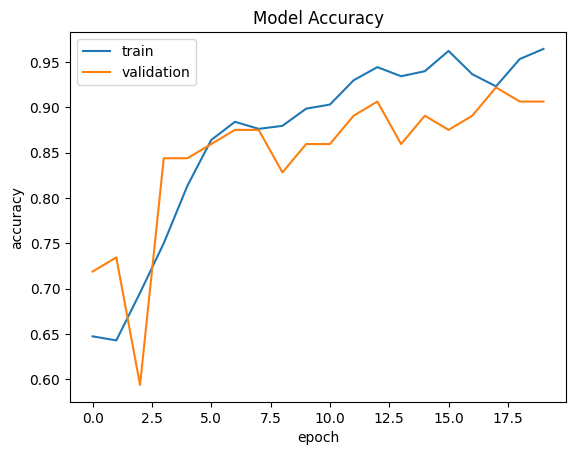

In [89]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

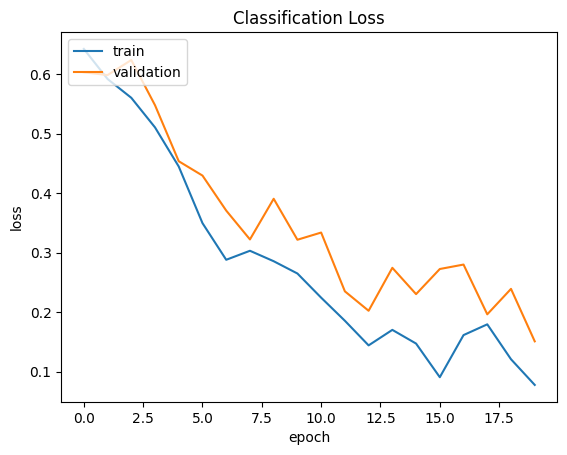

In [90]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [91]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [37]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

In [38]:
test_ds

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 244, 244, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

10


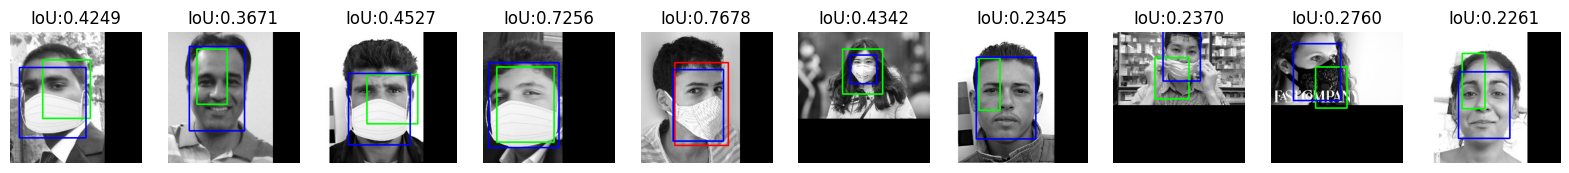

In [92]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(10).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

## Yolo

### Detekcja zwierząt morskich. 

To zadanie polega na zastosowaniu modelu Yolo do detekcji obiektów. Możesz dostosować parametry uczenia i inne aspekty w celu zoptymalizowania wyników.


Model Yolo adaptora, ale w tym przypadku przewiduje wartości numeryczne, wykorzystując warstwę `Dense` bez funkcji aktywacji.

1. Trening: Wytrenuj model YOLO v8 na danych z datasetu fall-23-into-vision-dataset. 
2. Skompiluj model. Trenuj model na danych treningowych za pomocą funkcji fit(), określając liczbę epok, rozmiar partii (batch size) i opcjonalnie zbiór walidacyjny.
3. Ocena wydajności modelu na danych testowych za pomocą vizualizacji detekcji ramke. 



In [93]:
import os
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


In [94]:
DATA_PATH = "/kaggle/input/fall-23-intro-to-vision-dataset/Dataset/detection/"

In [95]:
class_ids = [
    'jelly',
    'fish',
    'shark',
    'tuna',
]
class_mapping = {i: class_ids[i] for i in range(len(class_ids))}
class_mapping_r = {class_ids[i]: i for i in range(len(class_ids))}

In [96]:
def load_folder(path):
    image_paths, anns_paths, labels = [], [], []

    for root, dirs, files in os.walk(path):
        if len(files) == 0:
            continue

        label = os.path.basename(root)
        for file in files:
            name, ext = os.path.splitext(file)
            if ext == '.jpg':
                img_path = os.path.join(root, name)
                image_paths.append(img_path + '.jpg')
                anns_paths.append(img_path + '.txt')
                labels.append(label.lower())
    return image_paths, anns_paths, labels

In [97]:
def parse_annotation(anns_path):
    boxes = []
    with open(anns_path, 'r') as f:
        for line in f.readlines():
            boxes.append(
                [int(num) for num in line.split(',')[2:]]
            )
    return boxes

def load_dataset(path):
    image_paths, anns_paths, labels = load_folder(path)
    
    bbox, classes = [], []
    for i in range(len(anns_paths)):
        boxes = parse_annotation(anns_paths[i])
        bbox.append(boxes)
        classes.append([class_mapping_r[labels[i]]] * len(boxes))
    
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    

    return tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [98]:
train_data = load_dataset(os.path.join(DATA_PATH, 'train'))
val_data = load_dataset(os.path.join(DATA_PATH, 'val'))

In [100]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [101]:
SIZE = (640, 640)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=SIZE, scale_factor=(1.0, 1.0), bounding_box_format="xyxy"
        ),
    ]
)

In [102]:
BATCH_SIZE = 8

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [104]:
resizing = keras_cv.layers.JitteredResize(
    target_size=SIZE,
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

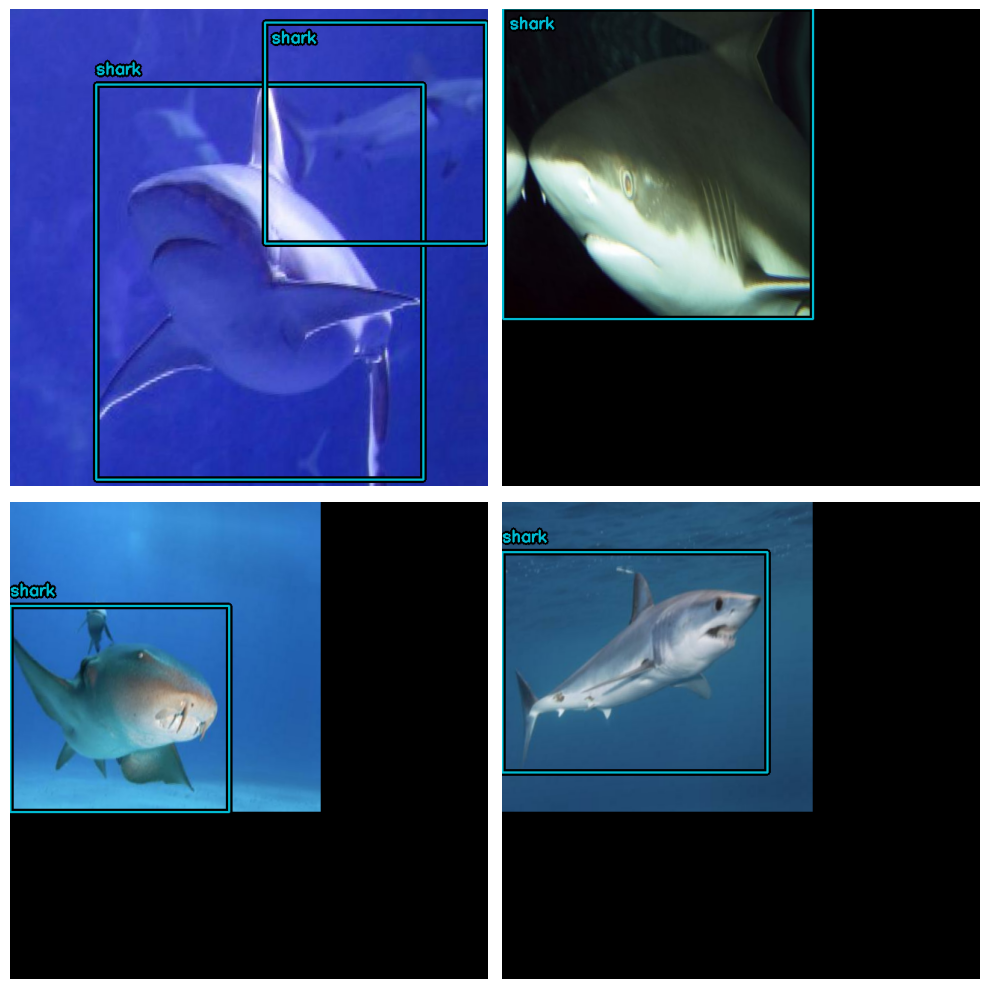

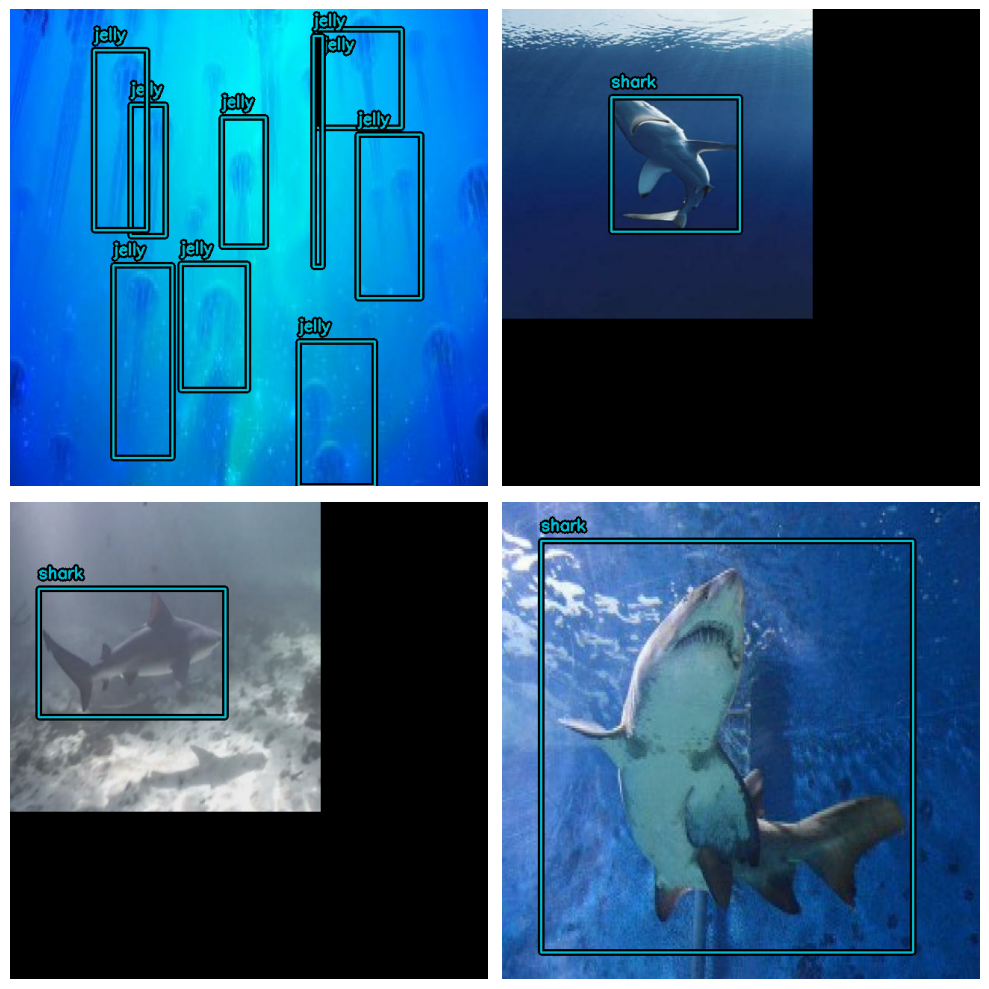

In [105]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [106]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [107]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",  # We will use yolov8 small backbone with coco weights
    load_weights=False
)

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_l_backbone_coco/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_l_backbone_coco/1' to your Kaggle notebook...


In [108]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [113]:
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_12 (Functional)       {'P3': (None, None, None,    1983174   ['input_14[0][0]']            
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

In [114]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

ValueError: Invalid classification loss for YOLOV8Detector: categorical_crossentropy. Classification loss should be a keras.Loss or the string 'binary_crossentropy'.

In [ ]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
87/87 [==============================] - 58s 641ms/step - loss: 4.0559 - box_loss: 2.9796 - class_loss: 1.0762 - val_loss: 4.2872 - val_box_loss: 3.1870 - val_class_loss: 1.1002
Epoch 2/5
87/87 [==============================] - 57s 643ms/step - loss: 4.0514 - box_loss: 2.9900 - class_loss: 1.0614 - val_loss: 4.1202 - val_box_loss: 3.0351 - val_class_loss: 1.0851
Epoch 3/5
87/87 [==============================] - 57s 649ms/step - loss: 3.9715 - box_loss: 2.9329 - class_loss: 1.0386 - val_loss: 4.0983 - val_box_loss: 3.0477 - val_class_loss: 1.0506
Epoch 4/5
74/87 [========================>.....] - ETA: 7s - loss: 4.0640 - box_loss: 3.0108 - class_loss: 1.0533

1/1 [==============================] - 6s 6s/step


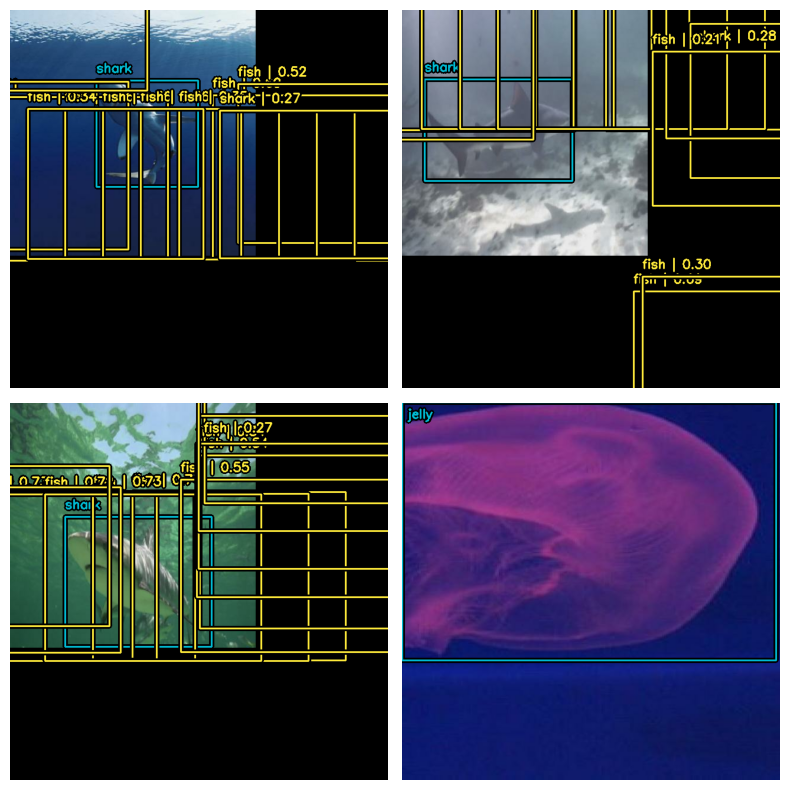

In [112]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

## Zadanie z wykorzystaniem Yolo 

1/1 [==============================] - 3s 3s/step


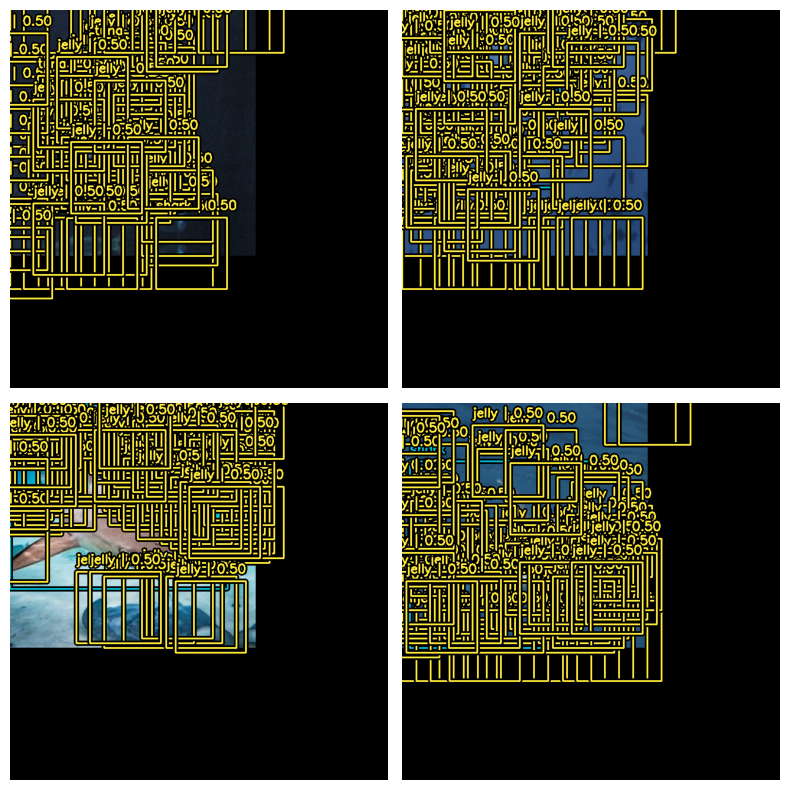

In [41]:
visualize_detections(yolo, dataset=train_ds, bounding_box_format="xyxy")